<h1> Research Project NB 1 </h1>

In [1]:
# Load Libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy import linalg as la

# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

In [2]:
# Loading in Image 

img = nib.load("cdmri12_r.nii")

arr =img.dataobj[:,:,:,:]


In [3]:
arr.shape

(83, 92, 56, 1344)

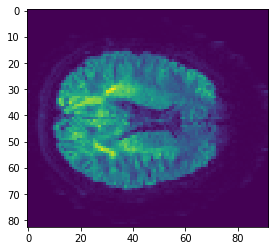

In [4]:
plt.imshow(arr[:,:,33,200])

Text(0.5, 1.0, 'Voxel Intensity against Parameter Values Set Number')

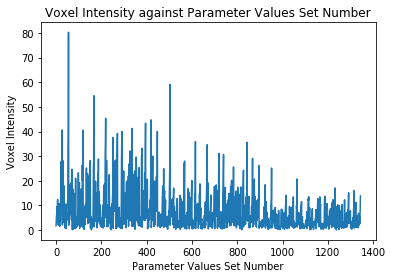

In [5]:
plt.plot(arr[40,40,33,:])
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Voxel Intensity against Parameter Values Set Number')

In [6]:
# Importing Parameters

p = np.loadtxt('parameters_new.txt')
p.shape

(1344, 6)

In [7]:
param = np.zeros([1344,6])
param = p.copy()
# Switching first two columns as:
# [x y z] --> [y -x z] (scanner to measurement coordinate system)
param[:, 0], param[:, 1] = p[:, 1], p[:, 0].copy()
param[:,1] = -param[:,1]
param

array([[-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  2.0000e+01,
         8.0000e+01],
       [-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  1.2364e+03,
         8.0000e+01],
       [-7.1803e-01,  5.2602e-01, -4.5578e-01,  3.0000e+03,  2.4727e+03,
         8.0000e+01],
       ...,
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  2.2961e+03,
         1.3000e+02],
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  3.5325e+03,
         1.3000e+02],
       [-6.8361e-01, -4.9906e-01,  5.3255e-01,  2.0000e+03,  7.3227e+03,
         1.3000e+02]])

In [8]:
b = p[:,3]
TI = p[:,4]
TE = p[:,5]

# Filter based on TI fulfilling condition
vals = TI>=TI_limit
indices = np.where(TI>TI_limit)
b0idx = np.where(b==0)   

TI=TI[indices]
TE=TE[indices]
param=param[indices]
b=b[indices]
res_selected = arr[:,:,:,indices]
param.shape

(1296, 6)

In [9]:
# From Stackoverflow: https://stackoverflow.com/questions/45637778/how-to-find-intersect-indexes-and-values-in-python
# Function takes unique elements from each array, puts them together, and concatenates
import numpy as np
def intersect_mtlb(a, b):
    a1, ia = np.unique(a, return_index=True)
    b1, ib = np.unique(b, return_index=True)
    aux = np.concatenate((a1, b1))
    aux.sort()
    c = aux[:-1][aux[1:] == aux[:-1]]
    return c, ia[np.isin(a1, c)], ib[np.isin(b1, c)]

c, idx_b0, ib = intersect_mtlb(indices, b0idx )

s0init = np.mean(arr[:,:,:,idx_b0], axis = 3) 

# Initial Values and Objective Function
b=b/1000
x0 = [300, 2, 1000, 100, 1, 1, 1, 0, 0, 0]

In [10]:
# Bounds on the fit
# lower = [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf];
# upper = [inf inf inf inf inf inf inf inf inf inf];

<h2> Fit 5 </h2>

In [11]:
# Fit5 Function

def Fit5(x,b, TI, TR, TE, param):            

    S= np.abs(x[0] *(1-x[1]* np.exp(-TI/x[2])+np.exp(-TR/x[2]))* np.exp(-TE/x[3])* np.exp(-b*(np.square(param[:,0])*x[4]+np.square(param[:,1])*x[5]+np.square(param[:,2])*x[6]+2*param[:,0]*param[:,1]*x[7]+2*param[:,0]*param[:,2]*x[8]+2*param[:,1]*param[:,2]*x[9])))
    return S

# Simple Exponential Cost Function

def Fit5Cost(x, b, TI, TR, TE, param, slslice):   
    # x[0] : Amplitude
    # x[1] : D value
    
    S= np.abs(x[0] *(1-x[1]* np.exp(-TI/x[2])+np.exp(-TR/x[2]))* np.exp(-TE/x[3])* np.exp(-b*(np.square(param[:,0])*x[4]+np.square(param[:,1])*x[5]+np.square(param[:,2])*x[6]+2*param[:,0]*param[:,1]*x[7]+2*param[:,0]*param[:,2]*x[8]+2*param[:,1]*param[:,2]*x[9])))
    res = slslice[0,:] -S
    return res

<h2> Model Fit to Grey Matter </h2>

In [12]:
# Grey Matter Voxel
slslice_GM = res_selected[19,47,33,:]

# Perform Non-Linear Least Squares Fit


# for x[4], values of 0.01, 1 would lead to a straight line at 0, 
# while 10 and 100 works fine

lsr = least_squares(Fit5Cost, x0, args=(b,TI, TR, TE, param, slslice_GM), max_nfev=5000)
cost = lsr.cost
jac = lsr.jac
values = lsr.x

# Computing Mean Diffusivity
# Diffusion Tensor
D = [[values[4], values[7], values[8]], 
     [values[7], values[5], values[9]], 
     [values[8], values[9], values[6]]]

# Eigenvectors and Eigenvalues 
[evecs , evals] = la.eig(D)
i = np.argsort(np.diag(evals))
evals = np.diag(evals)[i]

# Calculating MD 
MD = (evals[0]+evals[1]+evals[2])/3

print('Predicted values: ', values, '\n')
print('Mean Diffusivity: ', MD)

Predicted values:  [4.01971719e+02 1.71233194e+00 9.38713368e+03 8.45696879e+01
 1.21980320e+00 1.10809020e+00 1.13904951e+00 1.05204000e-02
 8.19526456e-03 8.29194949e-02] 

Mean Diffusivity:  0.31635260047011354


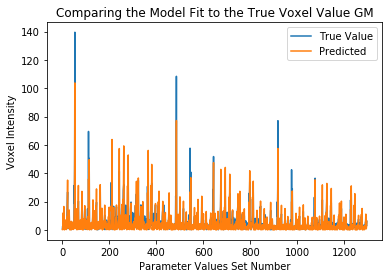

In [13]:
# Plotting Result

S_pred_GM = Fit5(values, b, TI, TR, TE, param)
p1 = plt.plot(slslice_GM[0,:])
p2 = plt.plot(S_pred_GM)
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Comparing the Model Fit to the True Voxel Value GM')
plt.legend((p1[0], p2[0]), ('True Value', 'Predicted'))

<h2> Model Fit White Matter </h2>

In [14]:
# White Matter Voxel
slslice_WM = res_selected[42,54,33,:]

# Perform Non-Linear Least Squares Fit

x0 = [300, 2, 1000, 100, 1, 1, 1, 0, 0, 0]
# for x[4], values of 0.01, 1 would lead to a straight line at 0, 
# while 10 and 100 works fine

lsr = least_squares(Fit5Cost, x0, args=(b,TI, TR, TE, param, slslice_WM), max_nfev=5000)
cost = lsr.cost
jac = lsr.jac
values = lsr.x

# Computing Mean Diffusivity
# Diffusion Tensor
D = [[values[4], values[7], values[8]], 
     [values[7], values[5], values[9]], 
     [values[8], values[9], values[6]]]

# Eigenvectors and Eigenvalues 
[evecs , evals] = la.eig(D)
i = np.argsort(np.diag(evals))
evals = np.diag(evals)[i]

# Calculating MD 
MD = (evals[0]+evals[1]+evals[2])/3

print('Predicted values: ', values, '\n')
print('Mean Diffusivity: ', MD)

Predicted values:  [ 4.44586619e+05  1.99950487e+00  1.96800805e+07  3.68621570e+01
  2.86841901e-01  1.14008583e+00  2.16125968e-01  5.81168466e-02
  3.03141925e-02 -7.58826847e-02] 

Mean Diffusivity:  0.29657875608100603


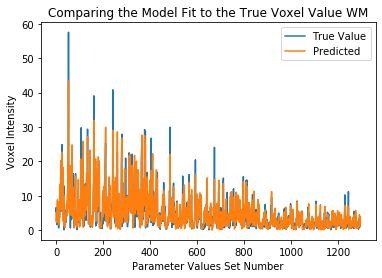

In [15]:
# Plotting Result

S_pred_WM = Fit5(values, b, TI, TR, TE, param)
p1 = plt.plot(slslice_WM[0,:])
p2 = plt.plot(S_pred_WM)
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Comparing the Model Fit to the True Voxel Value WM')
plt.legend((p1[0], p2[0]), ('True Value', 'Predicted'))

<h2> Model Fit CSF </h2>

In [33]:
# CSF Voxel
slslice_CSF = res_selected[46,43,33,:]

# Perform Non-Linear Least Squares Fit

x0 = [300, 2, 1000, 100, 1, 1, 1, 0, 0, 0]
# for x[4], values of 0.01, 1 would lead to a straight line at 0, 
# while 10 and 100 works fine

lsr = least_squares(Fit5Cost, x0, args=(b,TI, TR, TE, param, slslice_CSF), max_nfev=5000)
cost = lsr.cost
jac = lsr.jac
values = lsr.x

# Computing Mean Diffusivity
# Diffusion Tensor
D = [[values[4], values[7], values[8]], 
     [values[7], values[5], values[9]], 
     [values[8], values[9], values[6]]]

# Eigenvectors and Eigenvalues 
[evecs , evals] = la.eig(D)
i = np.argsort(np.diag(evals))
evals = np.diag(evals)[i]

# Calculating MD 
MD = (evals[0]+evals[1]+evals[2])/3

print('Predicted values: ', values, '\n')
print('Mean Diffusivity: ', MD)

Predicted values:  [2.37392766e+03 1.91525054e+00 3.17005929e+04 6.47651660e+01
 3.91218038e+00 2.62225117e+00 3.05965086e+00 7.30952553e-01
 2.10141722e-02 4.27235185e-01] 

Mean Diffusivity:  0.2923432024456846


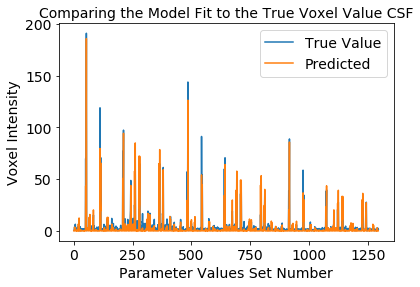

In [34]:
# Plotting Result

S_pred_CSF = Fit5(values, b, TI, TR, TE, param)
p1 = plt.plot(slslice_CSF[0,:])
p2 = plt.plot(S_pred_CSF)
plt.ylabel('Voxel Intensity')
plt.xlabel('Parameter Values Set Number')
plt.title('Comparing the Model Fit to the True Voxel Value CSF')
plt.legend((p1[0], p2[0]), ('True Value', 'Predicted'))

<h2> Plotting All Three Results </h2> 

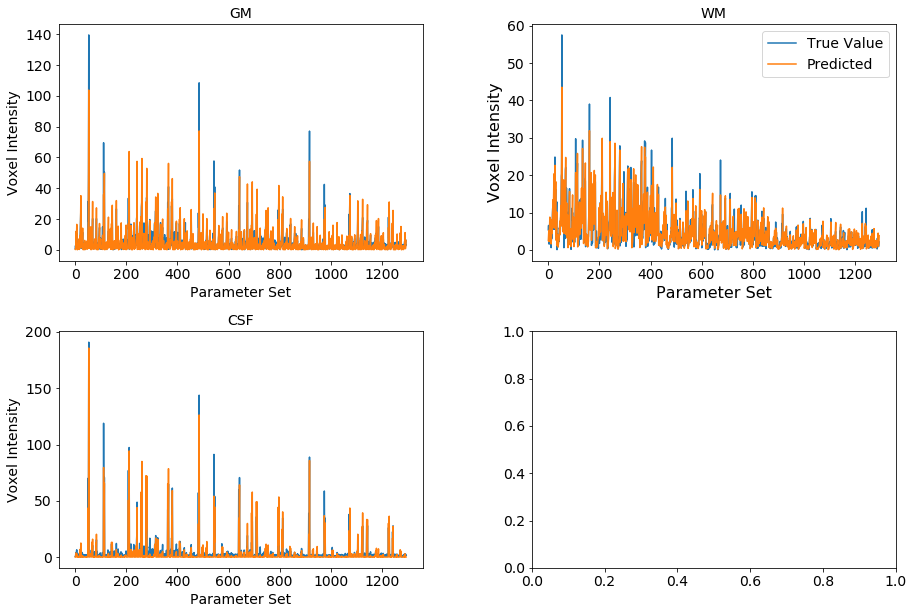

In [35]:
# Create figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)


# globally via a rcParams dictionary:

import matplotlib.pylab as pylab
params = {'legend.fontsize': 14,
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14 }
pylab.rcParams.update(params)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

# CSF Plot
p1_csf = ax3.plot(slslice_CSF[0,:])
p2_csf = ax3.plot(S_pred_CSF)
ax3.set(title='CSF')

ax3.set_ylabel('Voxel Intensity')
ax3.set_xlabel('Parameter Set')

# WM Plot
p1_wm = ax2.plot(slslice_WM[0,:])
p2_wm = ax2.plot(S_pred_WM)
ax2.set(title='WM')

ax2.legend((p1_wm[0], p2_wm[0]), ('True Value', 'Predicted'))
ax2.set_ylabel('Voxel Intensity', fontsize=16)
ax2.set_xlabel('Parameter Set', fontsize=16)

# GM Plot
p1_gm = ax1.plot(slslice_GM[0,:])
p2_gm = ax1.plot(S_pred_GM)
ax1.set(title='GM')

ax1.set_ylabel('Voxel Intensity')
ax1.set_xlabel('Parameter Set')

# Changing Figure Size
fig.set_figheight(10)
fig.set_figwidth(15)